In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

####IMPORT STATEMENTS

In [69]:
import io
import locale
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

####Look-up for City Names

In [3]:
jurisdiction_codes = {
    1: 'Carlsbad',2: 'Chula Vista',3: 'Coronado',4: 'Del Mar',5: 'El Cajon',6: 'Encinitas',7: 'Escondido',
    8: 'Imperial Beach',9: 'La Mesa',10: 'Lemon Grove',11: 'National City',12: 'Oceanside',13: 'Poway',
    14: 'San Diego',15: 'San Marcos',16: 'Santee',17: 'Solana Beach',18: 'Vista',19: 'Unincorporated'
}

jurisdictions = pd.Series(jurisdiction_codes, name='jurisdiction')

mode_codes = {
    'Auto SOV (Non-Toll)': (1, 1),'Auto SOV (Toll)': (2, 1),
    'Auto 2 Person (Non-Toll, Non-HOV)': (3, 2),'Auto 2 Person (Non-Toll, HOV)': (4, 2),'Auto 2 Person (Toll, HOV)': (5, 2),
    'Auto 3+ Person (Non-Toll, Non-HOV)': (6, 3),'Auto 3+ Person (Non-Toll, HOV)': (7, 3),'Auto 3+ Person (Toll, HOV)': (8, 3),
    'Walk': (9, 4),'Bike': (10, 5),
    'Walk-Local Bus': (11, 6),'Walk-Express Bus': (12, 6),'Walk-Light Rail': (14, 6),'Walk-Heavy Rail': (15, 6),
    'PNR-Local Bus': (16, 6),'PNR-Express Bus': (17, 6),'PNR-Light Rail': (19, 6),'PNR-Heavy Rail': (20, 6),
    'KNR-Local Bus': (21, 6),'KNR-Express Bus': (22, 6),'KNR-Light Rail': (24, 6),'KNR-Heavy Rail': (25, 6)
}



modes = pd.DataFrame({'mode_id': [1,2,3,4,5,6,7,8,9,10,11,12,14,15,16,17,19,20,21,22,24,25]
                      ,'super_mode' : ['Drive Alone','Drive Alone','HOV','HOV','HOV','HOV','HOV','HOV','Walk','Bike','Transit','Transit','Transit','Transit','Transit','Transit','Transit','Transit','Transit','Transit','Transit','Transit']}
                    ,index = ['Auto SOV (Non-Toll)','Auto SOV (Toll)'
                             ,'Auto 2 Person (Non-Toll, Non-HOV)','Auto 2 Person (Non-Toll, HOV)','Auto 2 Person (Toll, HOV)'
                             ,'Auto 3+ Person (Non-Toll, Non-HOV)','Auto 3+ Person (Non-Toll, HOV)','Auto 3+ Person (Toll, HOV)'
                             ,'Walk','Bike'
                             ,'Walk-Local Bus','Walk-Express Bus','Walk-Light Rail','Walk-Heavy Rail'
                             ,'PNR-Local Bus','PNR-Express Bus','PNR-Light Rail','PNR-Heavy Rail'
                             ,'KNR-Local Bus','KNR-Express Bus','KNR-Light Rail','KNR-Heavy Rail'
                            ])

####Load up the datasets

In [4]:
locale.setlocale(locale.LC_ALL, '')

base_csv_url = 'E:/Apps/sandag.github.io/transnet/baseline_mandatory_residents.csv'
alt_csv_url = 'E:/Apps/sandag.github.io/transnet/no_tnet_mandatory_residents.csv'

base_df = pd.read_csv(base_csv_url, index_col='tour_ij_id')
alt_df = pd.read_csv(alt_csv_url, index_col='tour_ij_id')

base_df = pd.merge(base_df, modes, left_on='mode_desc', right_index=True)
alt_df = pd.merge(alt_df, modes, left_on='mode_desc', right_index=True)

####Total Daily Time Change for Workers

In [5]:
daily_min_change = alt_df.tour_time.sum() - base_df.tour_time.sum()

print 'Total Daily Change in Time Spent on Mandatory Tours: {0:>12,.1f} minutes'.format(daily_min_change)
print 'Total Daily Change in Time Spent on Mandatory Tours: {0:>12,.1f} hours'.format(daily_min_change / 60.)

Total Daily Change in Time Spent on Mandatory Tours:  1,576,696.1 minutes
Total Daily Change in Time Spent on Mandatory Tours:     26,278.3 hours


In [79]:
base_df.tour_time.count()

1107866

####Total Annual Time Change for Workers

In [6]:
base_df.loc[:, 'annual_tour_time'] = base_df.tour_time * base_df.weeks_worked * base_df.avg_days_worked
alt_df.loc[:, 'annual_tour_time'] = alt_df.tour_time * alt_df.weeks_worked * alt_df.avg_days_worked

annual_min_change = alt_df.annual_tour_time.sum() - base_df.annual_tour_time.sum()

print 'Total Annual Change in Time Spent on Mandatory Tours: {0:>15,.0f} minutes'.format(annual_min_change)
print 'Total Annual Change in Time Spent on Mandatory Tours: {0:>15,.0f} hours'.format(annual_min_change / 60.)

Total Annual Change in Time Spent on Mandatory Tours:     382,251,871 minutes
Total Annual Change in Time Spent on Mandatory Tours:       6,370,865 hours


####Total Annual Monetary Savings for Workers
Value of time is derived from person table: hh_income / num_workers / annual_hours_worked

In [7]:
base_df.loc[:, 'annual_commute_cost'] = base_df.derived_hourly_salary * (base_df.annual_tour_time / 60)
alt_df.loc[:, 'annual_commute_cost'] = alt_df.derived_hourly_salary * (alt_df.annual_tour_time / 60)

annual_cost_difference = alt_df.annual_commute_cost.sum() - base_df.annual_commute_cost.sum()

print 'Total Annual Change in User Costs without the Project: {0}'.format(locale.currency(annual_cost_difference, grouping=True))
print 'Average Annual Commuter Savings without the Project: {0}'.format(locale.currency(annual_cost_difference / len(base_df)), grouping=True)

Total Annual Change in User Costs without the Project: $237,688,689.35
Average Annual Commuter Savings without the Project: $214.55


####Total and Average Annual Savings for Commuters by Jurisdiction
Value of time is derived from person table: hh_income / num_workers / annual_hours_worked

In [20]:
base_jurisdiction = base_df[['home_jurisdiction','tour_time', 'annual_tour_time', 'annual_commute_cost']].groupby('home_jurisdiction').sum()
alt_jurisdiction = alt_df[['home_jurisdiction','tour_time', 'annual_tour_time', 'annual_commute_cost']].groupby('home_jurisdiction').sum()
base_commuters = base_df[['home_jurisdiction','annual_commute_cost']].groupby('home_jurisdiction').count()
base_commuters.columns = ['commuters']

jurisdiction_diff = alt_jurisdiction - base_jurisdiction
jurisdiction_diff = jurisdiction_diff.join(jurisdictions)
print jurisdiction_diff[['jurisdiction','annual_commute_cost']].to_string(formatters={'annual_commute_cost': '${:,.2f}'.format})

commuter_savings = jurisdiction_diff['annual_commute_cost'] / base_commuters['commuters']
print pd.concat([jurisdictions, commuter_savings], axis=1, keys=['jurisdiction','avg_annual_commute_savings']).to_string(formatters={'avg_annual_commute_savings': '${:,.2f}'.format})

                     jurisdiction annual_commute_cost
home_jurisdiction                                    
1                        Carlsbad       $4,523,188.44
2                     Chula Vista      $21,597,151.10
3                        Coronado       $1,261,940.10
4                         Del Mar         $444,593.73
5                        El Cajon       $6,664,000.53
6                       Encinitas       $4,041,496.72
7                       Escondido      $13,961,763.91
8                  Imperial Beach       $1,006,413.25
9                         La Mesa       $7,687,242.42
10                    Lemon Grove       $2,353,539.13
11                  National City       $1,629,825.34
12                      Oceanside       $6,575,031.73
13                          Poway       $8,690,786.43
14                      San Diego      $92,908,624.07
15                     San Marcos       $4,185,888.27
16                         Santee      $13,586,344.33
17                   Solana 

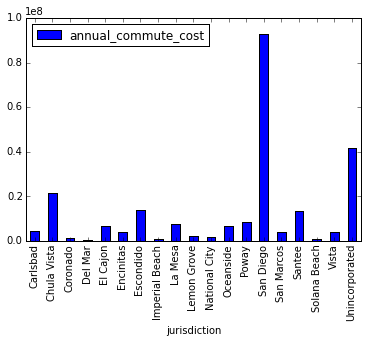

In [62]:
jurisdiction_diff[['jurisdiction','annual_commute_cost']].plot(kind='bar', y='annual_commute_cost', x='jurisdiction')

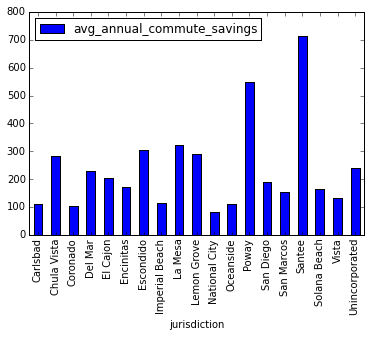

In [84]:
pd.concat([jurisdictions, commuter_savings], axis=1, keys=['jurisdiction','avg_annual_commute_savings']).plot(kind='bar', x='jurisdiction')

In [9]:
base_mode_sum = base_df[['super_mode','tour_time', 'annual_tour_time', 'annual_commute_cost']].groupby('super_mode').sum()
alt_mode_sum = alt_df[['super_mode','tour_time', 'annual_tour_time', 'annual_commute_cost']].groupby('super_mode').sum()

alt_mode_sum - base_mode_sum

,tour_time,annual_tour_time,annual_commute_cost
super_mode,,,
Bike,15900.987000,4.102955e+06,1.104025e+06
Drive Alone,1307985.913697,3.127369e+08,1.888364e+08
HOV,683109.803945,1.593784e+08,8.970282e+07
Transit,-440444.737262,-9.612709e+07,-4.388228e+07
Walk,10144.128040,2.160655e+06,1.927770e+06


In [17]:
base_mode = base_df[['super_mode','tour_time', 'annual_tour_time', 'annual_commute_cost','tour_distance']].groupby('super_mode').agg(['count','mean'])
alt_mode = alt_d['super_mode','tour_time', 'annual_tour_time', 'annual_commute_cost', 'tour_distance']].groupby('super_mode').agg(['count', 'mean'])
base_mode

tour_time             annual_tour_time                \
                count        mean            count          mean   
super_mode                                                         
Bike            14385   37.856062            14385   8082.532017   
Drive Alone    704642   50.410824           704642  11658.788654   
HOV            316258   49.039920           316258  11187.257663   
Transit         36931  111.360357            36931  24126.439655   
Walk            35650   37.748578            35650   7234.566461   

            annual_commute_cost              tour_distance             
                          count         mean         count       mean  
super_mode                                                             
Bike                      14385  3490.993241         14385   7.571212  
Drive Alone              704642  6874.263946        704642  26.310874  
HOV                      316258  5937.012172        316258  25.580671  
Transit                   36931  9440.669019         36931  17.395971  
Walk                      35650  2495.986470         35650   1.887429

In [80]:
alt_mode

tour_time             annual_tour_time                \
                count        mean            count          mean   
super_mode                                                         
Bike            14701   38.123967            14701   8187.890509   
Drive Alone    705802   52.181164           705802  12082.721643   
HOV            318183   50.890138           318183  11620.476706   
Transit         33532  109.513438            33532  23705.309867   
Walk            36010   37.652900            36010   7222.242428   

            annual_commute_cost              tour_distance             
                          count         mean         count       mean  
super_mode                                                             
Bike                      14701  3491.052465         14701   7.624793  
Drive Alone              705802  7130.514581        705802  25.664826  
HOV                      318183  6183.015467        318183  24.803993  
Transit                   33532  9088.961912         33532  16.185632  
Walk                      36010  2524.567828         36010   1.882645

In [22]:
alt_mode - base_mode

tour_time           annual_tour_time              \
                count      mean            count        mean   
super_mode                                                     
Bike              316  0.267905              316  105.358492   
Drive Alone      1160  1.770340             1160  423.932989   
HOV              1925  1.850218             1925  433.219043   
Transit         -3399 -1.846919            -3399 -421.129788   
Walk              360 -0.095678              360  -12.324033   

            annual_commute_cost             tour_distance            
                          count        mean         count      mean  
super_mode                                                           
Bike                        316    0.059224           316  0.053581  
Drive Alone                1160  256.250635          1160 -0.646049  
HOV                        1925  246.003296          1925 -0.776678  
Transit                   -3399 -351.707107         -3399 -1.210338  
Walk                        360   28.581359           360 -0.004784

In [81]:
print 'Total Daily Change in Person Miles Traveled (PMT) on Mandatory Tours: {0:>12,.1f} miles'.format(alt_df.tour_distance.sum() - base_df.tour_distance.sum())

Total Daily Change in Person Miles Traveled (PMT) on Mandatory Tours:   -719,371.5 miles


#CHANGE TO NON-MANDATORY TOURS

In [23]:
base_disc_csv_url = 'E:/Apps/sandag.github.io/transnet/baseline_non_work_residents.csv'
alt_disc_csv_url = 'E:/Apps/sandag.github.io/transnet/no_tnet_non_work_residents.csv'

base_disc_df = pd.read_csv(base_disc_csv_url, index_col='tour_ij_id')
alt_disc_df = pd.read_csv(alt_disc_csv_url, index_col='tour_ij_id')

base_disc_df = pd.merge(base_disc_df, modes, left_on='mode_desc', right_index=True)
alt_disc_df = pd.merge(alt_disc_df, modes, left_on='mode_desc', right_index=True)

In [27]:
print 'Total change in non-work tours without the project: {0:>12,}'.format(len(alt_disc_df) - len(base_disc_df))

Total change in non-work tours without the project:      -21,480


In [36]:
annualization_factor = 250
value_of_time = 12.5

daily_disc_min_change = alt_disc_df.tour_time.sum() - base_disc_df.tour_time.sum()

print 'Total Daily Change in Time Spent on Non-work Tours: {0:>12,.1f} minutes'.format(daily_disc_min_change)
print 'Total Daily Change in Time Spent on Non-work Tours: {0:>12,.1f} hours'.format(daily_disc_min_change / 60.)
print ''
print 'Total Daily Travel Savings without the Project:  ${0:>16,.2f}'.format(value_of_time * (daily_disc_min_change / 60.))
print 'Total Annual Travel Savings without the Project: ${0:>16,.2f}'.format(annualization_factor * value_of_time * (daily_disc_min_change / 60.))

Total Daily Change in Time Spent on Non-work Tours:  1,159,470.7 minutes
Total Daily Change in Time Spent on Non-work Tours:     19,324.5 hours

Total Daily Travel Savings without the Project:  $      241,556.39
Total Annual Travel Savings without the Project: $   60,389,097.27


In [82]:
residents_2012 = 3143418
annual_disc_savings = annualization_factor * value_of_time * (daily_disc_min_change / 60.)

print 'Total Average Annual Travel Savings without the project for non-mandatory: ${0:>16,.2f}'.format( annual_disc_savings / residents_2012)

Total Average Annual Travel Savings without the project for non-mandatory: $           19.21


In [45]:
base_disc_jur = base_disc_df[['home_jurisdiction','tour_time']].groupby('home_jurisdiction').agg(['count', 'mean', 'sum'])
alt_disc_jur = alt_disc_df[['home_jurisdiction','tour_time']].groupby('home_jurisdiction').agg(['count', 'mean', 'sum'])

disc_diff_jur = alt_disc_jur - base_disc_jur
disc_diff_jur.join(jurisdictions)

,"(tour_time, count)","(tour_time, mean)","(tour_time, sum)",jurisdiction
home_jurisdiction,,,,
1,-192,0.437978,41927.072222,Carlsbad
2,-1615,0.266234,21970.500279,Chula Vista
3,-215,0.183299,-3469.537876,Coronado
4,-101,1.704037,3406.623609,Del Mar
5,-320,0.416928,33688.440198,El Cajon
6,-753,0.394481,1684.887225,Encinitas
7,-1692,0.351582,3061.025300,Escondido
8,-416,-0.149600,-15778.100675,Imperial Beach
9,-745,0.857465,26761.501114,La Mesa
